In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from utils import TransformerLayer, TransformerEncoder
from utils import set_seed, load_data
from utils import train_model, eval_model

In [2]:
class Featuring(nn.Module):
    def __init__(self, input_dim, feature_dim):
        super().__init__()

        self.feature_dim = feature_dim

        self.conv1 = nn.Conv1d(input_dim, feature_dim, kernel_size=3,
                               padding=1)
        self.conv2 = nn.Conv1d(feature_dim, feature_dim, kernel_size=3,
                               padding=1)
        self.conv3 = nn.Conv1d(feature_dim, feature_dim, kernel_size=3,
                               padding=1)
        self.conv4 = nn.Conv1d(feature_dim, feature_dim, kernel_size=3,
                               padding=1)
        self.conv5 = nn.Conv1d(feature_dim, feature_dim, kernel_size=3,
                               padding=1)

        self.pool = nn.MaxPool1d(kernel_size=3, stride=3)
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)

        self.proj = nn.Linear(input_dim, feature_dim)
        layer = TransformerLayer(n_heads=3, d_model=feature_dim,
                                  ff_units=2*feature_dim, dropout=0.2)
        self.encoder = TransformerEncoder(layer, n_layers=2)

    def forward(self, x):
        c = x.permute(0, 2, 1)  # b, input_dim, 1500
        c = self.conv1(c)  # b, feature_dim, 1500,
        c = self.pool(c)  # b, feature_dim, 500
        c = self.conv2(c)
        c = self.pool(c) # b, feature_dim, 166
        c = self.conv3(c)
        c = self.pool(c) # b, feature_dim, 55
        c = self.conv4(c)
        c = self.pool(c) # b, feature_dim, 18
        c = self.conv5(c)  # b, feature_dim, 18
        c = self.adaptive_pool(c) # b, feature_dim, 1
        c = c.squeeze(-1)  # b, feature_dim

        t = self.proj(x) # b, 1500, feature_dim
        t = self.encoder(t) # b, 1500, feature_dim
        t = torch.mean(t, dim=1)  # b, feature_dim

        cat = torch.cat((c, t), dim=1)  # b, 2*feature_dim
        return cat


class Classifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()

        self.fc1 = nn.Linear(input_dim, 2 * input_dim)
        self.bn1 = nn.BatchNorm1d(2 * input_dim)
        self.fc2 = nn.Linear(2 * input_dim, input_dim)
        self.bn2 = nn.BatchNorm1d(input_dim)
        self.fc3 = nn.Linear(input_dim, input_dim // 2)
        self.bn3 = nn.BatchNorm1d(input_dim // 2)
        self.fc4 = nn.Linear(input_dim // 2, input_dim // 4)
        self.bn4 = nn.BatchNorm1d(input_dim // 4)
        self.fc5 = nn.Linear(input_dim // 4, 1)

        self.dropout = nn.Dropout(0.5)
        self.leaky_relu = nn.LeakyReLU(0.3)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)

        x = self.fc3(x)
        x = self.bn3(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)

        x = self.fc4(x)
        x = self.bn4(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)

        x = self.fc5(x)

        x = x.squeeze(-1)
        x = F.sigmoid(x)

        return x


class InteractionModel(nn.Module):
    def __init__(self, featuring, classifier):
        super().__init__()

        self.featuring = featuring
        self.classifier = classifier

    def forward(self, x1, x2):
        x1 = self.featuring(x1)  # b, 2*feature_dim
        x2 = self.featuring(x2)  # b, 2*feature_dim
        x = torch.cat((x1, x2), dim=1)  # b, 4*feature_dim
        x = self.classifier(x)
        return x

In [3]:

spe = "yeast"

# data_dir = "ppi-data"
# train_file = os.path.join(data_dir, spe, "action/train_action_20.tsv")
# val_file = os.path.join(data_dir, spe, "action/test_action_20.tsv")
# epochs = 10

from google.colab import drive

drive.mount('/content/drive')
data_dir = "drive/MyDrive/ppi-data"
train_file = os.path.join(data_dir, spe, "action/train_action.tsv")
val_file = os.path.join(data_dir, spe, "action/test_action.tsv")
epochs = 100

embedding_h5 = os.path.join(data_dir, spe, "seq/pipr.embedding.h5")

input_dim = 13
feature_dim = 18
batch_size = 32
lr = 0.001

set_seed(1234)

device = "cuda" if torch.cuda.is_available() else "cpu"

train_loader = load_data(train_file, batch_size, embedding_h5, train=True)
val_loader = load_data(val_file, batch_size, embedding_h5, train=False)


In [4]:
featuring = Featuring(input_dim, feature_dim)
classifier = Classifier(4 * feature_dim)

model = InteractionModel(featuring, classifier)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)

Epoch: 1 -- loss: 0.6765, val_loss: 0.6931, accuracy: 0.5000
Epoch: 2 -- loss: 0.6996, val_loss: 0.6930, accuracy: 0.5000
Epoch: 3 -- loss: 0.7666, val_loss: 0.6930, accuracy: 0.5000
Epoch: 4 -- loss: 0.8158, val_loss: 0.6931, accuracy: 0.5000
Epoch: 5 -- loss: 0.6739, val_loss: 0.6930, accuracy: 0.5000
Epoch: 6 -- loss: 0.7800, val_loss: 0.6929, accuracy: 0.5000
Epoch: 7 -- loss: 0.6697, val_loss: 0.6928, accuracy: 0.5000
Epoch: 8 -- loss: 0.6195, val_loss: 0.6927, accuracy: 0.5000
Epoch: 9 -- loss: 0.6785, val_loss: 0.6927, accuracy: 0.5000
Epoch: 10 -- loss: 0.6088, val_loss: 0.6928, accuracy: 0.5000


C:\Users\bc\miniconda3\envs\torch\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1: 0.0000


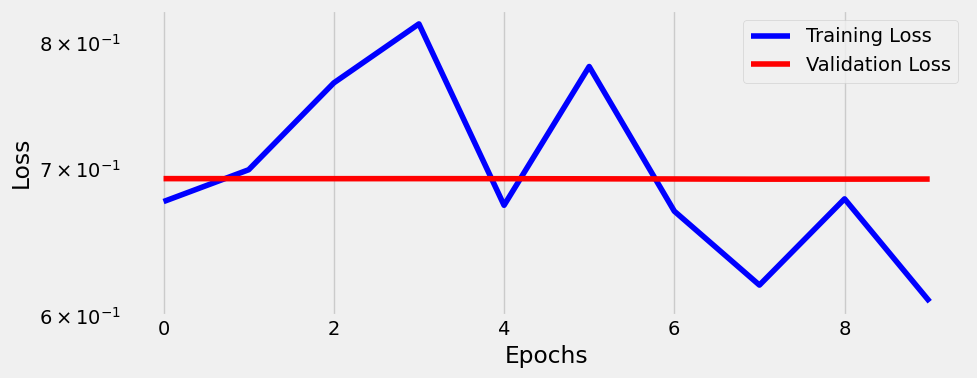

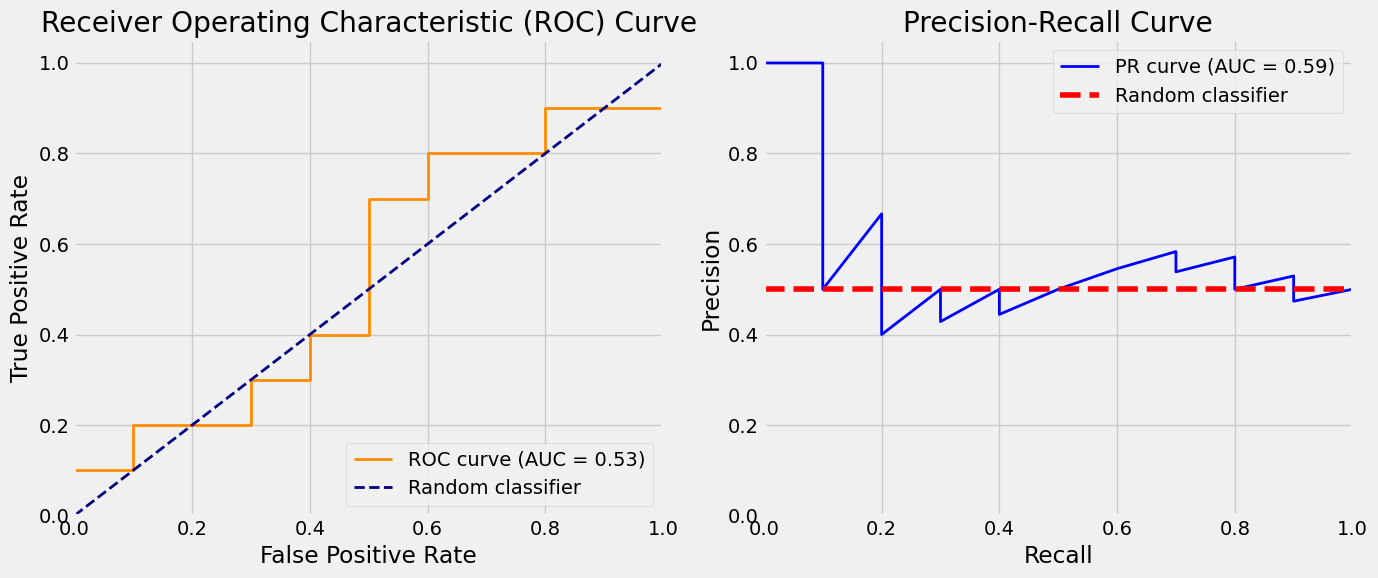

ROC AUC: 0.5300
PR AUC: 0.5896


In [5]:
train_model(model, train_loader, val_loader, optimizer, epochs, device)

eval_model(model, val_loader, device)